In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [19]:
accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")
# display(accidents_moon)

C:\Users\Hana\AppData\Local\Temp\ipykernel_36128\4041037844.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")


In [20]:
# Nastavljanje pravilnega časovnega pasu
accidents_moon['NastanekDatumCas'] = pd.to_datetime(accidents_moon['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
accidents_moon['NastanekDatumCas'] = accidents_moon['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {accidents_moon['NastanekDatumCas'].dtype}")
#display(accidents_moon)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy - dnevi brez luninih men

Preverila bom, če se ritmičnost nesreč, ki so se zgodile izven tistih dni, ko se menjajo lunine mene, razlikuje od ritmičnosti nesreč, ki so se zgodile v času menjanja luninih men.

In [21]:
# Maska za luno
accidents_moon['moon_phase'] = accidents_moon['moon_phase'].fillna('None')
moon_mask = (accidents_moon['moon_phase'] == 'None')

accidents_none = accidents_moon[moon_mask]
# display(accidents_none)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = accidents_none['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsNone",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

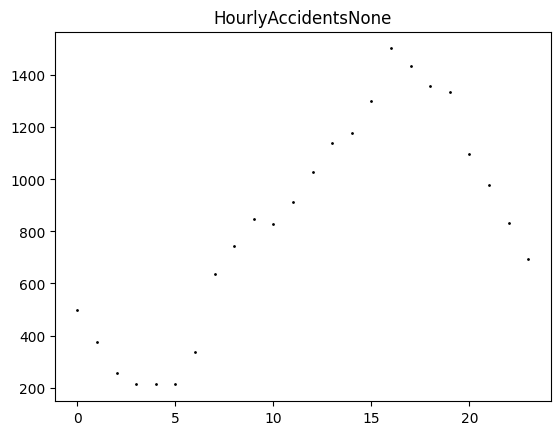

In [22]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsNone"])

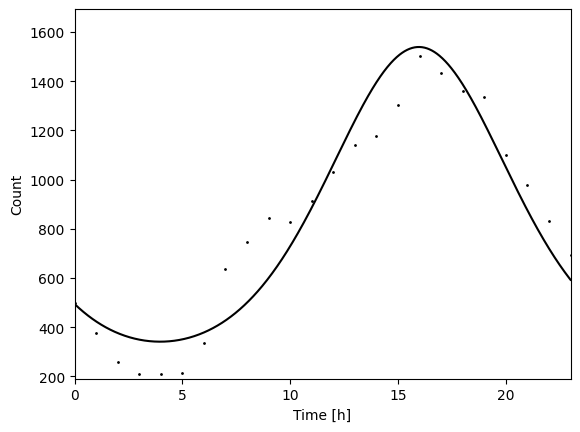

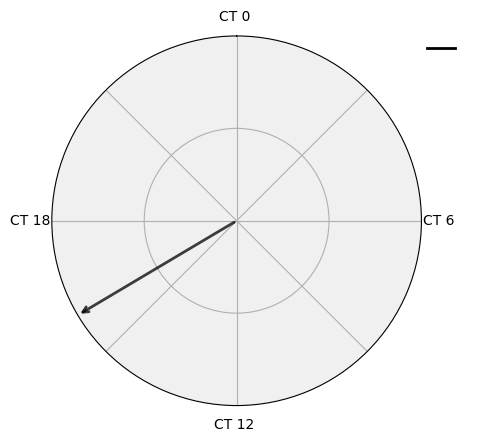

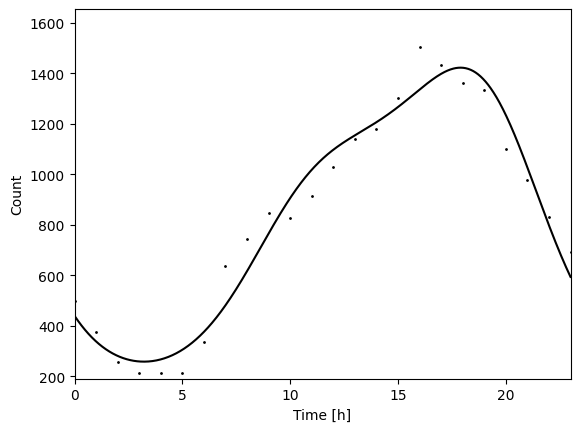

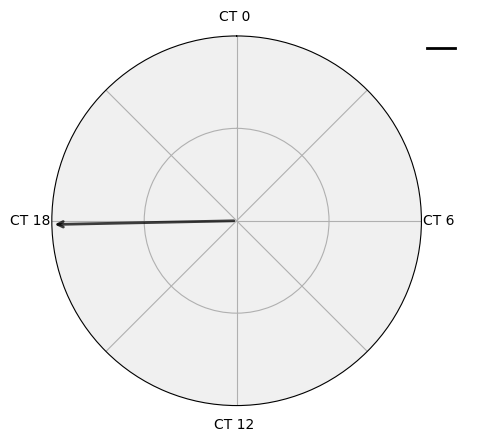

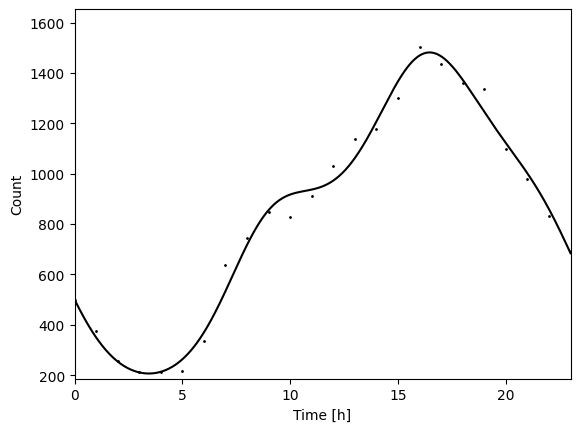

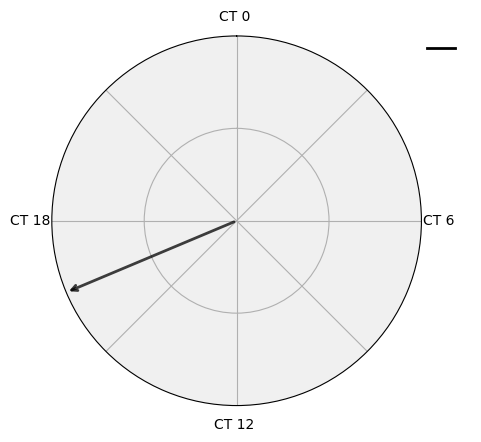

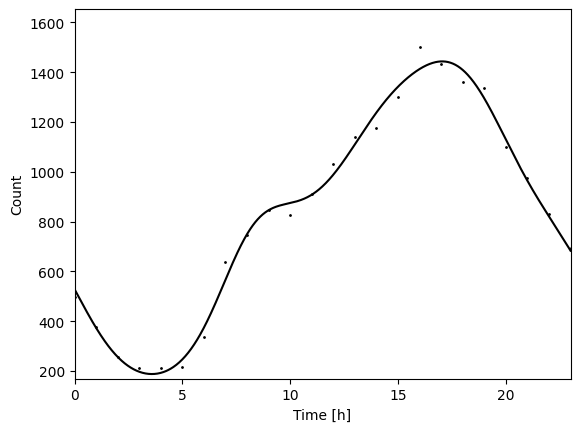

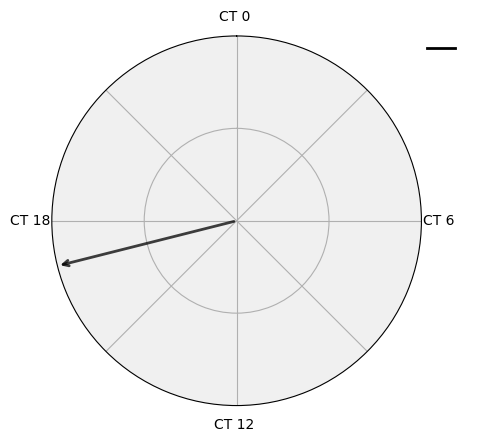

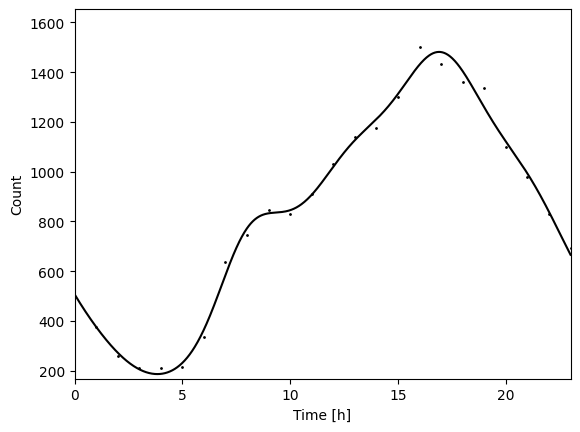

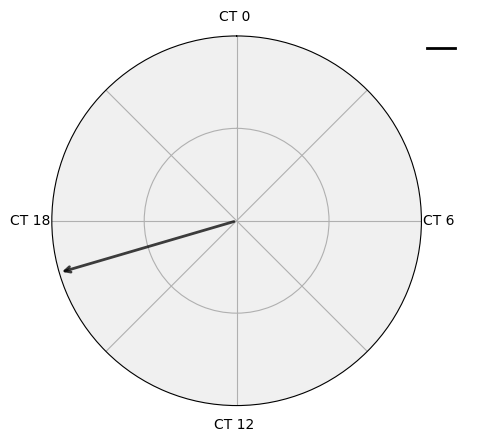

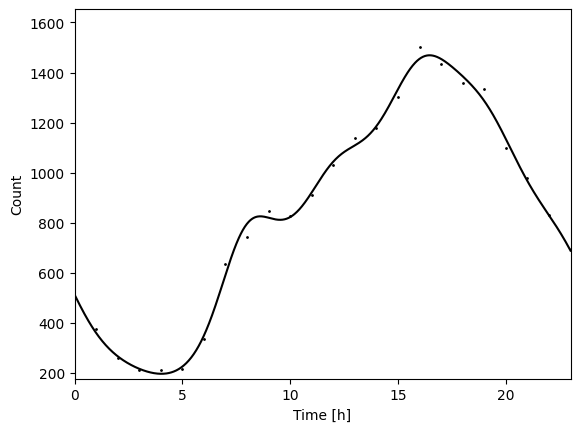

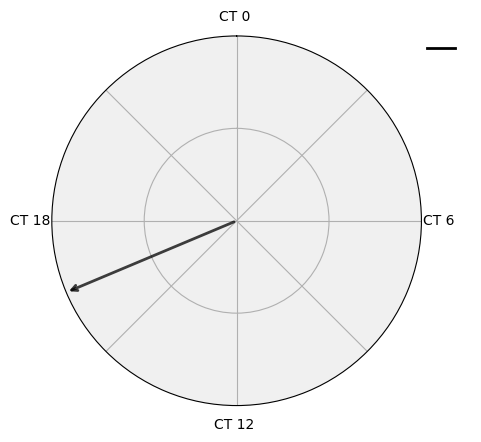

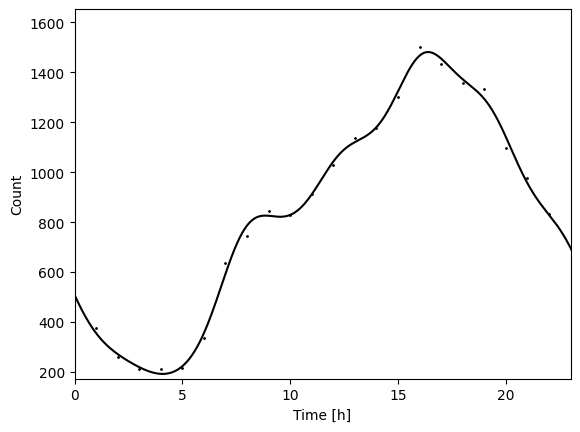

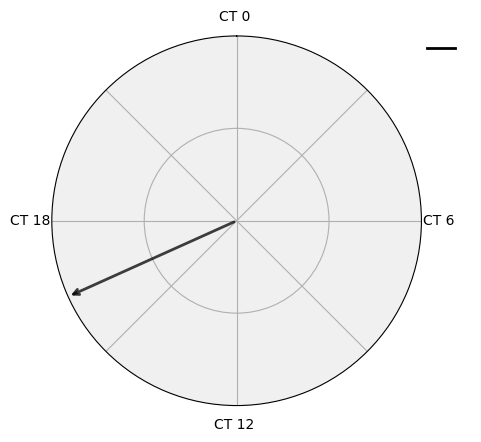

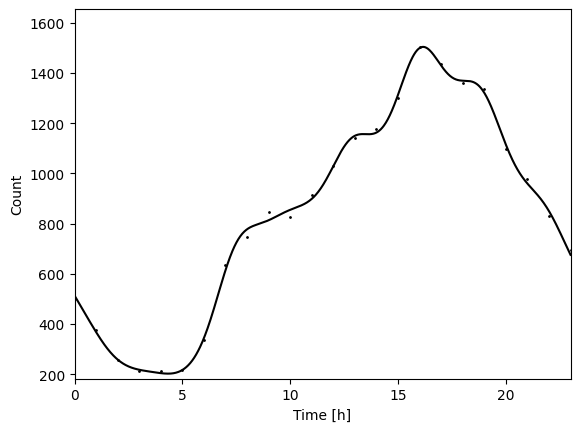

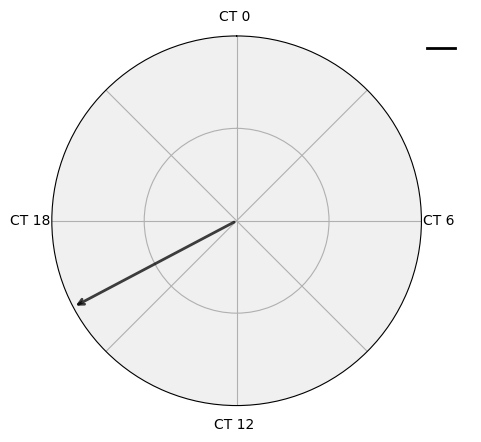

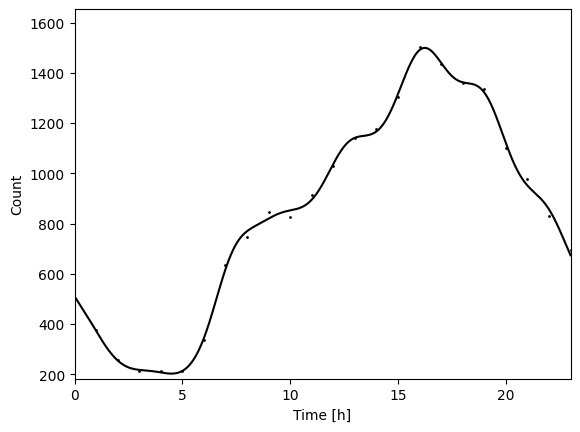

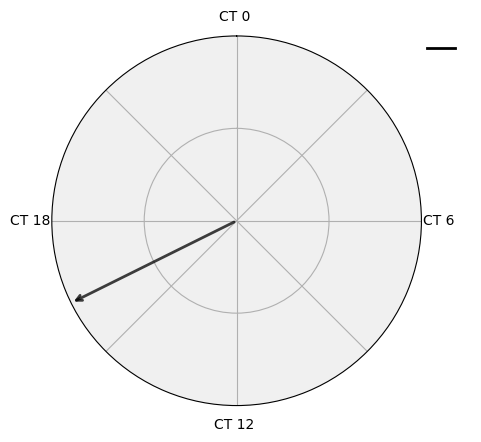

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


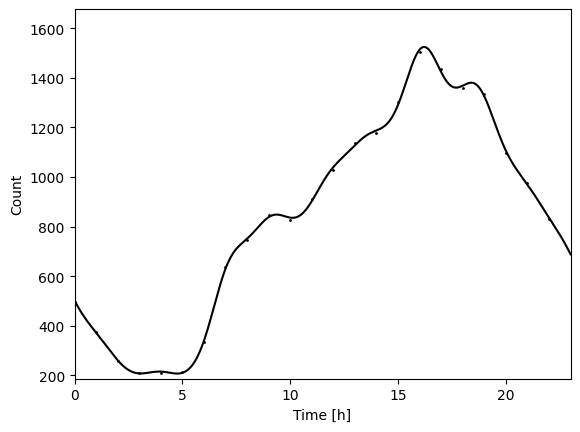

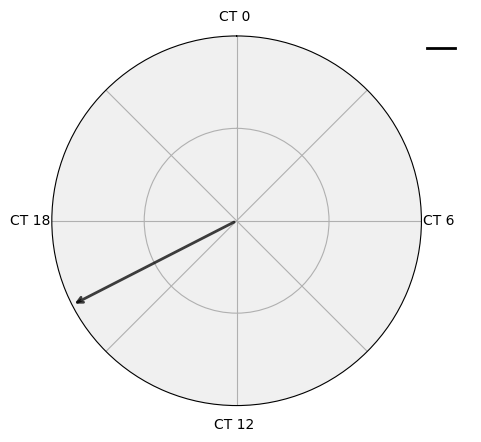

In [23]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsNone', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [24]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNone,24.0,1.0,5.764624e-13,5.764624e-13,398443.215135,-152.264109,0.156179,598.984665,2.106974,940.386404,[15.951951951951951],[1539.362707859488],[3.987987987987988],[341.4049701647052]
1,HourlyAccidentsNone,24.0,2.0,8.547827e-17,9.497586e-17,158249.864122,-139.716498,0.225716,581.643052,1.591237,840.019760,[17.92192192192192],[1421.6422564513261],[3.219219219219219],[258.3767075318531]
2,HourlyAccidentsNone,24.0,3.0,1.226554e-21,1.533192e-21,50869.652487,-124.919306,0.307719,637.295372,1.968606,844.103955,[16.48048048048048],[1481.3856188530683],[3.4594594594594597],[206.80858353589093]
3,HourlyAccidentsNone,24.0,4.0,9.124159e-23,1.303451e-22,32645.595655,-119.089837,0.340025,627.649019,1.817658,815.759549,[17.057057057057058],[1443.4085679587413],[3.6036036036036037],[188.11798530797807]
4,HourlyAccidentsNone,24.0,5.0,2.344635e-23,3.907726e-23,24486.795617,-114.712501,0.364283,647.334319,1.855395,834.011806,[16.912912912912912],[1481.3461244430775],[3.843843843843844],[186.67748655925914]
5,HourlyAccidentsNone,24.0,6.0,2.962716e-24,7.406791e-24,15851.252949,-109.689118,0.392122,636.128845,1.968606,832.807327,[16.48048048048048],[1468.922818111284],"[4.036036036036036, 9.513513513513514]","[196.67848266830998, 811.6972264842053]"
6,HourlyAccidentsNone,24.0,7.0,1.435503e-23,2.871005e-23,12553.591580,-108.702728,0.397589,644.585289,1.993764,836.787864,[16.384384384384383],[1481.3731528782334],"[4.084084084084084, 9.513513513513514]","[192.20257567099287, 821.6780152644908]"
7,HourlyAccidentsNone,24.0,8.0,3.301679e-26,1.650839e-25,6016.963405,-99.448263,0.448875,650.695850,2.056658,853.106891,"[13.357357357357357, 16.144144144144143]","[1156.4722852128073, 1503.7351116796665]",[4.324324324324325],[202.41104089713713]
8,HourlyAccidentsNone,24.0,9.0,9.535432e-26,3.178477e-25,5714.977826,-98.044864,0.456653,648.142474,2.031500,850.926100,[16.24024024024024],[1499.0685740667498],[4.468468468468468],[202.7980153300888]
9,HourlyAccidentsNone,24.0,10.0,1.114696e-31,1.114696e-30,1435.231771,-80.435536,0.554240,658.517697,2.044079,866.293325,"[16.19219219219219, 18.4024024024024]","[1524.724545121889, 1380.7136037503888]","[3.075075075075075, 4.756756756756757, 10.0900...","[208.23363478574169, 207.7756279781649, 835.83..."


### Katero je najboljše število komponent

In [25]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNone,24.0,8.0,3.301679e-26,1.650839e-25,6016.963405,-99.448263,0.448875,650.69585,2.056658,853.106891,"[13.357357357357357, 16.144144144144143]","[1156.4722852128073, 1503.7351116796665]",[4.324324324324325],[202.41104089713713]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


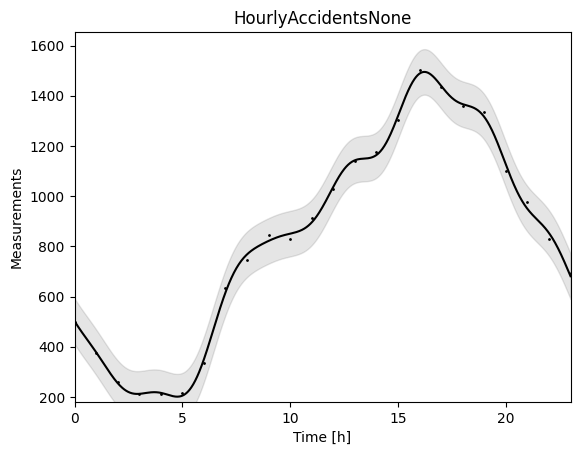

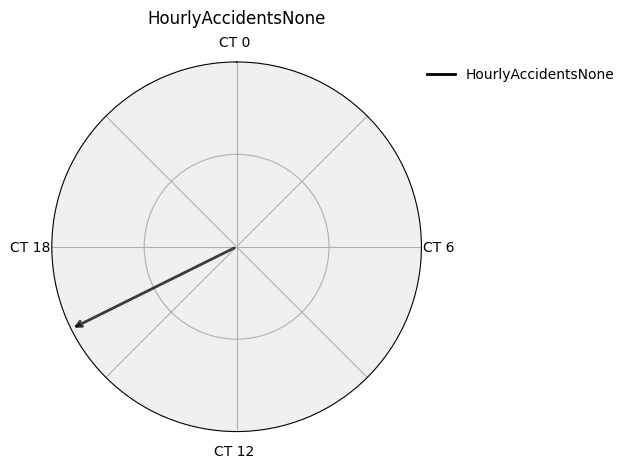

In [26]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [27]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsNone",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [28]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

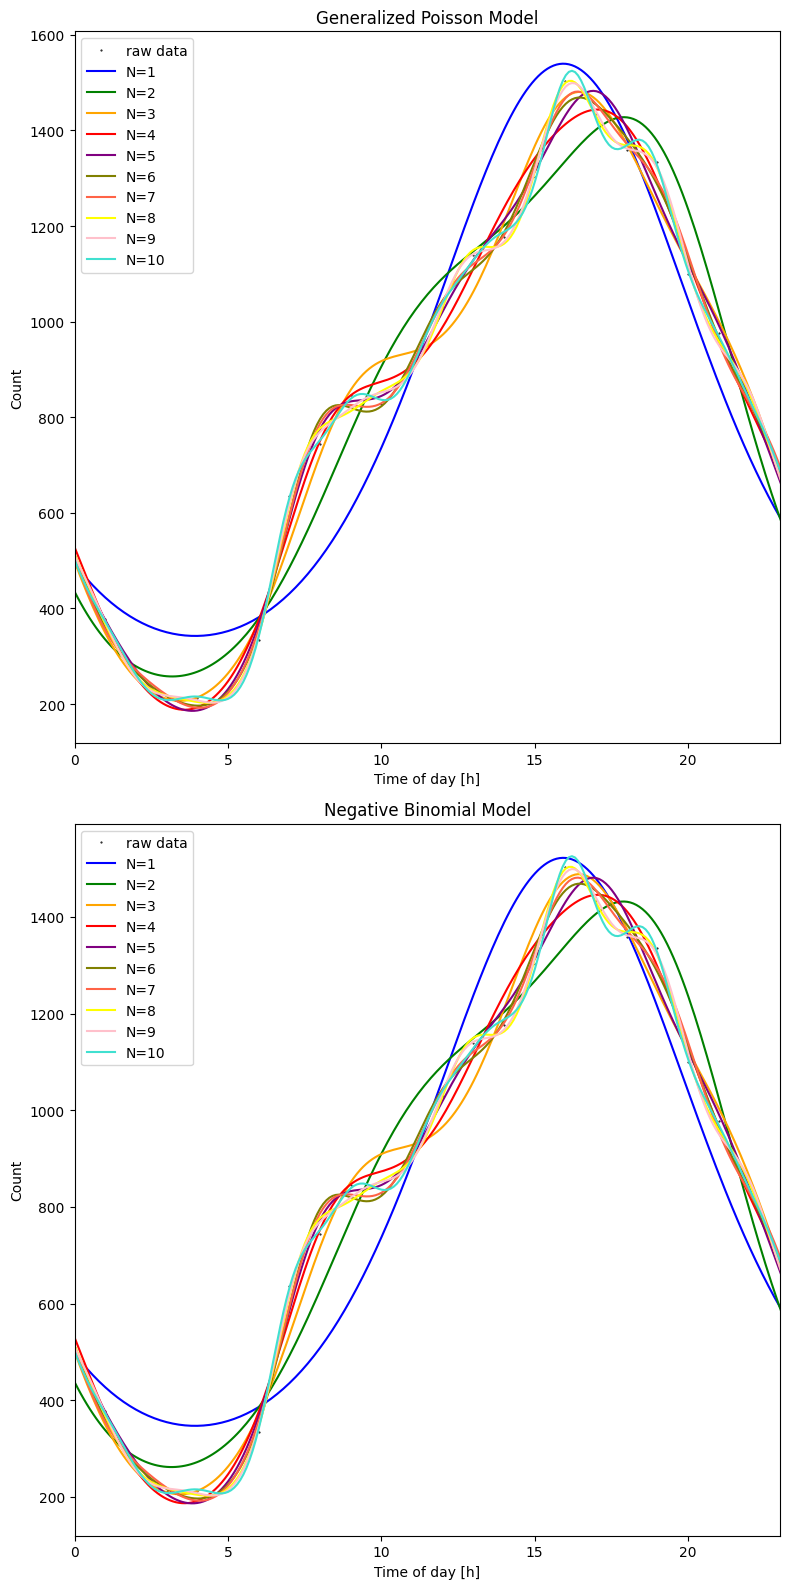

In [29]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [30]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,598.53,941.10,[15.92],[1539.63],5.811798e-13,400770.862227,312.544517,317.256733,-152.272259,"[-5.698841943859918, -5.557642190496381, -5.98...",832.430358,"[493.2426232104117, 423.03618321945277, 376.43...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[493.2426232104117, 485.0512178566582, 477.128..."
1,gen_poisson,2,584.98,842.79,[17.92],[1427.77],8.730829e-17,157437.425190,291.476402,298.544725,-139.738201,"[-5.67084364803884, -5.351590659338797, -4.872...",830.986166,"[435.46706378163617, 335.1581461859006, 279.15...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[435.46706378163617, 423.1392952699856, 411.34..."
2,gen_poisson,3,636.83,843.64,[16.42],[1480.48],2.633342e-21,50664.195640,267.423144,276.847575,-125.711572,"[-4.365986658896304, -4.794324422628165, -4.06...",831.416667,"[499.1272697841836, 348.9960298638128, 253.732...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[499.1272697841836, 481.9983638617814, 465.264..."
3,gen_poisson,4,627.76,815.92,[17.02],[1443.68],2.340703e-22,32556.066763,260.159878,271.940416,-120.079939,"[-4.867972269030474, -3.9785717154364875, -3.7...",831.416667,"[528.4703010023445, 373.1793786694703, 256.610...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[528.4703010023445, 512.3201223339106, 496.181..."
4,gen_poisson,5,648.48,834.34,[16.92],[1482.82],5.641835e-23,24525.078409,255.293895,269.430541,-115.646947,"[-4.035836762940448, -3.7909087163407094, -4.0...",831.827028,"[507.3448545262846, 376.2938353897498, 272.484...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[507.3448545262846, 493.0061794917279, 478.950..."
5,gen_poisson,6,636.03,832.74,[16.42],[1468.77],2.974805e-24,15850.987595,247.386990,263.879743,-109.693495,"[-4.202288855671782, -4.259016753182038, -3.77...",831.416667,"[513.2586189624035, 360.08474978995486, 266.82...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[513.2586189624035, 495.7516026468759, 478.578..."
6,gen_poisson,7,644.61,836.78,[16.42],[1481.39],1.525531e-23,12543.571695,249.538041,268.386902,-108.769021,"[-4.057732405494505, -4.56409787697595, -4.018...",831.416667,"[508.7206530684082, 355.53478457426456, 271.55...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[508.7206530684082, 490.2032132675508, 472.243..."
7,gen_poisson,8,650.55,853.09,"[13.41, 16.12]","[1156.57, 1503.64]",8.507395e-25,6009.787822,242.015400,263.220369,-103.007700,"[-4.207064889414255, -3.905837881674927, -3.58...",831.416667,"[513.3864730853336, 368.0724326083408, 258.702...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[513.3864730853336, 498.6194728489607, 483.913..."
8,gen_poisson,9,648.07,851.08,[16.22],[1499.15],5.119752e-24,5716.643074,244.926137,268.487214,-102.463068,"[-4.109188083122831, -3.7998177495342134, -3.6...",831.416667,"[510.5190587962299, 372.9982018913733, 255.258...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[510.5190587962299, 497.08566847901926, 483.76..."
9,gen_poisson,10,658.47,866.32,"[16.22, 18.42]","[1524.79, 1380.67]",2.195676e-24,1435.027757,242.128752,268.045936,-99.064376,"[-3.938843128899009, -3.798422915703668, -3.61...",831.416667,"[502.42095584238655, 373.10625105531665, 261.5...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[502.42095584238655, 486.17457453973685, 470.8..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [31]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 8


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [32]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 8
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian

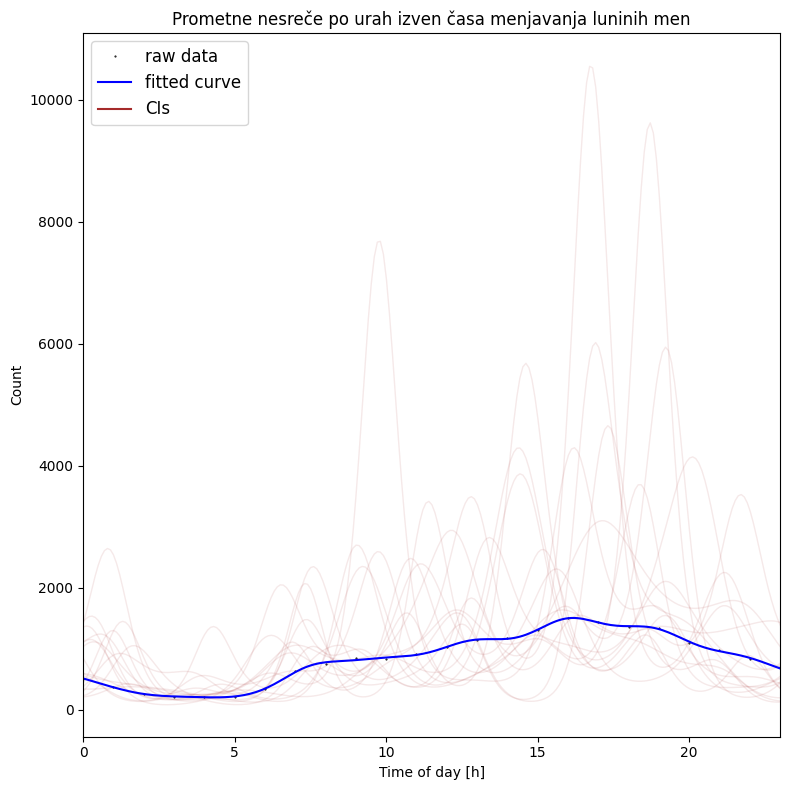

Intervali zaupanja:


,0,1
0,6.393387,6.783582
1,-0.898373,-0.335384
2,-0.686439,-0.157091
3,-0.474804,-0.016556
4,-0.473338,0.370035
5,-0.460711,0.547818
6,-0.112160,0.315105
7,-0.367369,0.397163
8,-0.413912,0.479781
9,-0.262195,0.244439


In [33]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah izven časa menjavanja luninih men', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [34]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  war

LinAlgError: Singular matrix